## EDSA Unsupervised Learning Sprint
---
# **Movie Recommender Systems**
---
![recommender_images.png](https://i.imgur.com/jH0BZJo.png)

### The team:
>Thapelo Makhalanyane | Kabelo Mbewe | Reitumetse Nchoe | Mpho Nonyane | Hercules Smith

# Introduction
---

Almost everything we buy or consume today is influenced by some form of recommendation; whether that's from friends, family, external reviews, and, more recently, from the sources selling you the product. When you log on to Netflix or Amazon Prime, for example, you will see a list of movies and television shows the service thinks you will like based on your past watching (and rating) history. Facebook suggests people it thinks you may know and would probably like to add. It also curates a News Feed for you based on the posts you've liked, the people you've be-friended, and the pages you've followed. Amazon recommends items to you as you browse for a particular product. It shows you similar products from a competing source and suggests auxiliary items frequently bought together with the product.

### The Goal:
- To build a model than can produce an estimated rating for given user and movie combination (that doesn't yet exist) quickly and accurately. This part of the project focuses on the best possible model performance, within reason (we cannot train until the heat-death of the universe, for example)

## Steps:
1. Bring in our data and Explore it a bit, gathering some insights about our data.
2. Format our data in a way that allows us to perform unsupervised learning tasks.
3. Build and evaluate some models
4. Refine our favourite model
5. Produce a submission
6. Conclusion

## Data Overview
---
This dataset consists of several million 5-star ratings obtained from users of the online MovieLens movie recommendation service. The MovieLens dataset has long been used by industry and academic researchers to improve the performance of explicitly-based recommender systems, and now you get to as well!

For this Predict, we'll be using a special version of the MovieLens dataset which has enriched with additional data, and resampled for fair evaluation purposes.

## Source
The data for the MovieLens dataset is maintained by the GroupLens research group in the Department of Computer Science and Engineering at the University of Minnesota. Additional movie content data was legally scraped from IMDB

## Supplied Files
Dataset | Description
--- | ---
`genome_scores` |  The file genome-scores.csv contains movie-tag relevance data in the following format: movieId, tagId and relevance.
`genome_tags` | The second file, genome-tags.csv, provides the tag descriptions for the tag IDs in the genome file, in the following format: tagId, tag.
`imdb_data` | Additional movie metadata scraped from IMDB using the links.csv file.
`links` | File providing a mapping between a MovieLens ID and associated IMDB and TMDB IDs.
`tags` | User assigned for the movies within the dataset.
`test` | The test split of the dataset. Contains user and movie IDs with no rating data.
`train` | The training split of the dataset. Contains user and movie IDs with associated rating data.

<br/>

<br/>

# Additional Information
---
The below information is provided directly from the MovieLens dataset description files:

### Ratings Data File Structure (`train.csv`)
All ratings are contained in the file train.csv. Each line of this file after the header row represents one rating of one movie by one user, and has the following format:

```
userId | movieId | rating | timestamp
```

The lines within this file are ordered first by userId, then, within user, by movieId.

Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).

Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

### Tags Data File Structure (`tags.csv`)
All tags are contained in the file tags.csv. Each line of this file after the header row represents one tag applied to one movie by one user, and has the following format:

```
userId | movieId | tag | timestamp
```

The lines within this file are ordered first by userId, then, within user, by movieId.

Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and purpose of a particular tag is determined by each user.

Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970

### Movies Data File Structure (`movies.csv`)
Movie information is contained in the file movies.csv. Each line of this file after the header row represents one movie, and has the following format:

```
movieId | title | genres
```

Movie titles are entered manually or imported from https://www.themoviedb.org/, and include the year of release in parentheses. Errors and inconsistencies may exist in these titles.

Genres are a pipe-separated list, and are selected from the following:

```
Action | Adventure | Animation | Children's | Comedy | Crime | Documentary | Drama | Fantasy | 
Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western (no genres listed)
```

### Links Data File Structure (`links.csv`)
Identifiers that can be used to link to other sources of movie data are contained in the file links.csv. Each line of this file after the header row represents one movie, and has the following format:

```
movieId | imdbId | tmdbId
```

movieId is an identifier for movies used by https://movielens.org. E.g., the movie Toy Story has the link https://movielens.org/movies/1.

imdbId is an identifier for movies used by http://www.imdb.com. E.g., the movie Toy Story has the link http://www.imdb.com/title/tt0114709/.

tmdbId is an identifier for movies used by https://www.themoviedb.org. E.g., the movie Toy Story has the link https://www.themoviedb.org/movie/862.

Use of the resources listed above is subject to the terms of each provider.

### Tag Genome (genome-scores.csv and `genome_tags.csv`)
As described in this article, the tag genome encodes how strongly movies exhibit particular properties represented by tags (atmospheric, thought-provoking, realistic, etc.). The tag genome was computed using a machine learning algorithm on user-contributed content including tags, ratings, and textual reviews.

The genome is split into two files. The file `genome_scores.csv` contains movie-tag relevance data in the following format:

```
movieId | tagId | relevance
```
The second file, `genome_tags.csv`, provides the tag descriptions for the tag IDs in the genome file, in the following format:

```
tagId | tag
```

## Before we start:
Our Notebook uses a custom version of Surprise - the only difference is that its faster than the original. 

So we need to install some packages to ensure everything works as expected.

## Also:
The Notebook expects the script under `scripts/data_cleaning.py` to be run from the project root before running the Notebook. Make a folder called `cleaned` in the root directory - otherwise you'll get errors.

In [1]:
!pip install git+https://github.com/ProfHercules/Surprise
!pip install plotly seaborn

  Cloning https://github.com/ProfHercules/Surprise to /private/var/folders/_w/py4g90n97jq7r622flx1x74c0000gn/T/pip-req-build-qpynd7zy
  Running command git clone -q https://github.com/ProfHercules/Surprise /private/var/folders/_w/py4g90n97jq7r622flx1x74c0000gn/T/pip-req-build-qpynd7zy


# Step 1: Show me the data

(we start with imports)

In [2]:
import pandas as pd

from plotly import express as px

## Helper Functions

Throughout this Notebook we make extensive use of helper functions that either complete a task within the Notebook, or preprocesses data before the Notebook even runs (to save on Kernel memory usage)

### The file:
The following code is the contents of our `scripts/data_cleaning.py` file, containing all data cleaning code.

```python
import numpy as np
import pandas as pd

from helpers import runParallel

# read csv files
def clean_genome():
    genome_scores = pd.read_csv("data/genome-scores.csv")
    genome_tags = pd.read_csv("data/genome-tags.csv")

    genome_data = genome_scores.merge(genome_tags, on="tagId")

    genome_tag_vec = genome_data.pivot(
        index="movieId", columns="tag", values="relevance"
    )
    genome_tag_vec["movieId"] = genome_tag_vec.index

    cols = ["movieId"] + [col for col in genome_tag_vec.columns if col != "movieId"]
    genome_tag_vec = genome_tag_vec[cols]
    genome_tag_vec.reset_index(inplace=True, drop=True)
    genome_tag_vec.to_csv(
        "cleaned/genome_tag_vec.csv",
        index=False,
    )


def clean_imdb():
    imdb_data = pd.read_csv("data/imdb_data.csv")
    budget_to_num = lambda budget: int("".join([c for c in budget if c.isnumeric()]))

    imdb_data["budget"] = imdb_data["budget"].apply(
        lambda b: np.nan if b is np.nan or b[0] != "$" else budget_to_num(b)
    )
    imdb_data.title_cast.fillna("", inplace=True)
    imdb_data.director.fillna("", inplace=True)
    imdb_data.runtime.fillna(int(imdb_data.runtime.median()), inplace=True)
    imdb_data.budget.fillna(int(imdb_data.budget.median()), inplace=True)
    imdb_data.plot_keywords.fillna("", inplace=True)

    imdb_data.to_csv(
        "cleaned/imdb_data.csv",
        index=False,
    )


def clean_movies():
    movies = pd.read_csv("data/movies.csv")

    movies["year"] = (
        movies.title.str.strip()
        .str[-6:]
        .str.extract(r"\(([0-9]{4})\)")
        .fillna(0)
        .astype(int)
    )

    normal_year_mean = movies[movies.year != 0].year.median()
    movies["year"].replace(0, normal_year_mean, inplace=True)

    movies["title"] = movies.title.str.strip().str.replace(
        r"\(([0-9]{4})\)", "", regex=True
    )
    movies["title"] = (
        movies["title"].str.strip().str.replace(r"(.*), The$", r"The \1", regex=True)
    )

    movies["title"] = movies["title"] + movies.year.apply(lambda y: f" ({int(y)})")

    movies["genres"] = movies.genres.str.replace(
        "(no genres listed)", "unknown", regex=False
    )

    movies.to_csv(
        "cleaned/movies.csv",
        index=False,
    )


def build_full_combine():
    train = pd.read_csv("data/train.csv")
    movies = pd.read_csv("cleaned/movies.csv")
    imdb_data = pd.read_csv("cleaned/imdb_data.csv")
    genome_tag_vec = pd.read_csv("cleaned/genome_tag_vec.csv")

    full_combine = (
        movies.merge(imdb_data, on="movieId", how="left")
        .merge(genome_tag_vec, on="movieId", how="left")
        .set_index("movieId", drop=True)
    )

    normal_year_mean = full_combine[full_combine.year != 0].year.mean()
    full_combine["year"].replace(0, normal_year_mean, inplace=True)

    # movies.year.fillna(int(movies.year.median()), inplace=True)
    # movies.genres.fillna("<unknown>", inplace=True)
    full_combine.title = full_combine.title.str.strip().str.replace(
        r"(.*), The$", r"The \1", regex=True
    )
    full_combine.title_cast.fillna(" ", inplace=True)
    full_combine.director.fillna(" ", inplace=True)
    full_combine.runtime.fillna(int(full_combine.runtime.median()), inplace=True)
    full_combine.budget.fillna(int(full_combine.budget.median()), inplace=True)
    full_combine.plot_keywords.fillna(" ", inplace=True)

    full_combine["cast_size"] = full_combine.title_cast.str.split("|").apply(len)
    full_combine["genre_count"] = full_combine.genres.str.split("|").apply(len)

    movie_groups = train.set_index("movieId", drop=True).groupby("movieId")
    full_combine["rating_mean"] = movie_groups.rating.mean()
    full_combine["rating_std"] = movie_groups.rating.std().fillna(0)

    q3 = movie_groups.rating.quantile(0.75)
    q1 = movie_groups.rating.quantile(0.25)

    full_combine["rating_iqr"] = q3 - q1
    full_combine["rating_count"] = movie_groups.apply(len)

    full_combine.fillna(0, inplace=True)

    full_combine["movieId"] = full_combine.index.values
    full_combine.reset_index(inplace=True, drop=True)
    full_combine.to_csv(
        "cleaned/full_combine.csv",
        index=False,
    )


if __name__ == "__main__":
    print("Cleaning...")
    runParallel([clean_genome, clean_imdb, clean_movies])
    print("Generating full-combine file")
    build_full_combine()
    print("Done!")

```

In [3]:
# takes in a dataframe and spits out a mini report
def demo_frame(df: pd.DataFrame):
    print(df.info())
    return df.head()

In [4]:
base_path = "./data"
genome_scores = pd.read_csv(f'{base_path}/genome-scores.csv')
genome_tags = pd.read_csv(f'{base_path}/genome-tags.csv')
imdb_data = pd.read_csv(f'{base_path}/imdb_data.csv')
# links = pd.read_csv(f'{base_path}/links.csv')  # we won't be using links
movies = pd.read_csv(f'{base_path}/movies.csv')
tags = pd.read_csv(f'{base_path}/tags.csv')
test = pd.read_csv(f'{base_path}/test.csv')
train = pd.read_csv(f'{base_path}/train.csv')

We'll start our journey by exploring the `genome` data, since that sounds the most interesting!

In [5]:
demo_frame(genome_scores)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15584448 entries, 0 to 15584447
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 356.7 MB
None


movieId  tagId  relevance
0        1      1    0.02875
1        1      2    0.02375
2        1      3    0.06250
3        1      4    0.07575
4        1      5    0.14075

In [6]:
demo_frame(genome_tags)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB
None


tagId           tag
0      1           007
1      2  007 (series)
2      3  18th century
3      4         1920s
4      5         1930s

Every movie is tagged with one of 1'128 tags, each movie-tag pair has a `relevance` score which indicates how *strongly* the `movie` is associated with the `tag`.

To use this data we may have to perform a `merge` and a `pivot`.

We can use the following functions to build a nice `genome_tag_vec` dataframe:

```python
def clean_genome():
    genome_scores = pd.read_csv("data/genome-scores.csv")
    genome_tags = pd.read_csv("data/genome-tags.csv")

    genome_data = genome_scores.merge(genome_tags, on="tagId")

    genome_tag_vec = genome_data.pivot(
        index="movieId", columns="tag", values="relevance"
    )
    genome_tag_vec["movieId"] = genome_tag_vec.index

    cols = ["movieId"] + [col for col in genome_tag_vec.columns if col != "movieId"]
    genome_tag_vec = genome_tag_vec[cols]
    genome_tag_vec.reset_index(inplace=True, drop=True)
    genome_tag_vec.to_csv(
        "cleaned/genome_tag_vec.csv",
        index=False,
    )
```
The above functions comes from the `scrips/data_cleaning.py` file. It should be run before this Notebook so we can just import the results:


In [7]:
genome_tag_vec = pd.read_csv('cleaned/genome_tag_vec.csv')

demo_frame(genome_tag_vec)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13816 entries, 0 to 13815
Columns: 1129 entries, movieId to zombies
dtypes: float64(1128), int64(1)
memory usage: 119.0 MB
None


movieId      007  007 (series)  18th century    1920s    1930s    1950s  \
0        1  0.02875       0.02375       0.06250  0.07575  0.14075  0.14675   
1        2  0.04125       0.04050       0.06275  0.08275  0.09100  0.06125   
2        3  0.04675       0.05550       0.02925  0.08700  0.04750  0.04775   
3        4  0.03425       0.03800       0.04050  0.03100  0.06500  0.03575   
4        5  0.04300       0.05325       0.03800  0.04100  0.05400  0.06725   

     1960s    1970s   1980s  ...  world politics  world war i  world war ii  \
0  0.06350  0.20375  0.2020  ...         0.04050      0.01425       0.03050   
1  0.06925  0.09600  0.0765  ...         0.05250      0.01575       0.01250   
2  0.04600  0.14275  0.0285  ...         0.06275      0.01950       0.02225   
3  0.02900  0.08650  0.0320  ...         0.05325      0.02800       0.01675   
4  0.02775  0.07650  0.0215  ...         0.05350      0.02050       0.01425   

   writer's life  writers  writing    wuxia     wwii   zombie  zombies  
0        0.03500  0.14125  0.05775  0.03900  0.02975  0.08475  0.02200  
1        0.02000  0.12225  0.03275  0.02100  0.01100  0.10525  0.01975  
2        0.02300  0.12200  0.03475  0.01700  0.01800  0.09100  0.01775  
3        0.03875  0.18200  0.07050  0.01625  0.01425  0.08850  0.01500  
4        0.02550  0.19225  0.02675  0.01625  0.01300  0.08700  0.01600  

[5 rows x 1129 columns]

We know `Toy Story (1995)` has `movieId == 1`, so let's see what top 10 tags are most relevant to it:

In [8]:
sorted_tags = genome_tag_vec[genome_tag_vec.movieId == 1].T.sort_values(0, ascending=False)
sorted_tags.iloc[1:11]

0
toys                0.99925
computer animation  0.99875
pixar animation     0.99575
kids and family     0.98575
animation           0.98425
kids                0.98000
pixar               0.96450
children            0.95975
cartoon             0.95475
animated            0.94725

All of these are very agreeable tags! We might end up using this data to improve model performance later. For now, let's keep Exploring! We'll look at the IMDB data next:

In [9]:
demo_frame(imdb_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        15189 non-null  float64
 4   budget         7906 non-null   object 
 5   plot_keywords  16200 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB
None


movieId                                         title_cast  \
0        1  Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...   
1        2  Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...   
2        3  Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...   
3        4  Whitney Houston|Angela Bassett|Loretta Devine|...   
4        5  Steve Martin|Diane Keaton|Martin Short|Kimberl...   

              director  runtime       budget  \
0        John Lasseter     81.0  $30,000,000   
1   Jonathan Hensleigh    104.0  $65,000,000   
2  Mark Steven Johnson    101.0  $25,000,000   
3       Terry McMillan    124.0  $16,000,000   
4       Albert Hackett    106.0  $30,000,000   

                                       plot_keywords  
0                   toy|rivalry|cowboy|cgi animation  
1                   board game|adventurer|fight|game  
2                         boat|lake|neighbor|rivalry  
3  black american|husband wife relationship|betra...  
4                    fatherhood|doberman|dog|mansion

Pretty self-explanatory; there is a need to clean the dataframe a bit - splitting on the pipe (|) and transforming `budget` to be numeric. Let's see what that looks like.

Again, we make use of a `scripts/data_cleaning.py` function:

```python
def clean_imdb():
    imdb_data = pd.read_csv("data/imdb_data.csv")
    budget_to_num = lambda budget: int("".join([c for c in budget if c.isnumeric()]))

    imdb_data["budget"] = imdb_data["budget"].apply(
        lambda b: np.nan if b is np.nan or b[0] != "$" else budget_to_num(b)
    )
    imdb_data.title_cast.fillna("", inplace=True)
    imdb_data.director.fillna("", inplace=True)
    imdb_data.runtime.fillna(int(imdb_data.runtime.median()), inplace=True)
    imdb_data.budget.fillna(int(imdb_data.budget.median()), inplace=True)
    imdb_data.plot_keywords.fillna("", inplace=True)

    imdb_data.to_csv(
        "cleaned/imdb_data.csv",
        index=False,
    )
```
Which has already been run.

In [10]:
imdb_data = pd.read_csv('cleaned/imdb_data.csv')

demo_frame(imdb_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        27278 non-null  float64
 4   budget         27278 non-null  float64
 5   plot_keywords  16200 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 1.2+ MB
None


movieId                                         title_cast  \
0        1  Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...   
1        2  Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...   
2        3  Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...   
3        4  Whitney Houston|Angela Bassett|Loretta Devine|...   
4        5  Steve Martin|Diane Keaton|Martin Short|Kimberl...   

              director  runtime      budget  \
0        John Lasseter     81.0  30000000.0   
1   Jonathan Hensleigh    104.0  65000000.0   
2  Mark Steven Johnson    101.0  25000000.0   
3       Terry McMillan    124.0  16000000.0   
4       Albert Hackett    106.0  30000000.0   

                                       plot_keywords  
0                   toy|rivalry|cowboy|cgi animation  
1                   board game|adventurer|fight|game  
2                         boat|lake|neighbor|rivalry  
3  black american|husband wife relationship|betra...  
4                    fatherhood|doberman|dog|mansion

Now we can mine some data about our movies!

In [11]:
from collections import Counter

def flatten_list(lst):
    return [item for sublist in lst for item in sublist]

unique_actors_per_movie = imdb_data.title_cast.str.split('|').fillna("").apply(set)
print("Median # of actors per movie:", round(unique_actors_per_movie.apply(len).median()))
print("Total # of actors (in dataset):", len(set.union(*unique_actors_per_movie)))

actor_by_movies = pd.Series(Counter(flatten_list(unique_actors_per_movie))).sort_values(ascending=True)

fig = px.bar(
    data_frame=actor_by_movies.iloc[-20:], 
    x=0, 
    height=640,
    labels={"0": "# of Movies"}, 
    orientation='h', 
    title='Number of movies per actor'
)
fig.show()

Median # of actors per movie: 15
Total # of actors (in dataset): 121035


In [12]:
director_by_movies = pd.Series(Counter(imdb_data.director)).sort_values(ascending=True)

fig = px.bar(
    data_frame=director_by_movies.iloc[-20:-2], 
    x=0, 
    height=640,
    labels={"0": "# of Movies"}, 
    orientation='h', 
    title='Number of movies per director'
)
fig.show()

In [13]:
movie_keywords = imdb_data.plot_keywords.str.split('|').fillna("").apply(set)
keyword_by_movies = pd.Series(Counter(flatten_list(movie_keywords))).sort_values(ascending=True)

fig = px.bar(
    data_frame=keyword_by_movies.iloc[-20:], 
    x=0, 
    height=640,
    labels={"0": "# of Movies"}, 
    orientation='h', 
    title='Top Keywords'
)
fig.show()

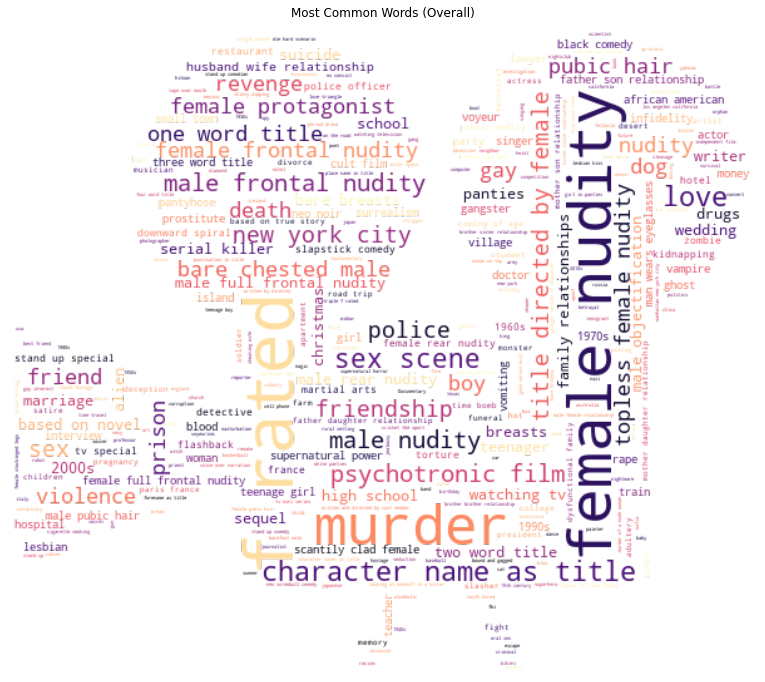

In [14]:
from wordcloud import WordCloud, STOPWORDS
import codecs
import imageio
import base64
import numpy as np

from matplotlib import pyplot as plt

mask = imageio.imread('https://i.imgur.com/k5R2GhY.jpg')

def gen_wordcloud(word_freq, title, savefig=False):
    plt.figure(figsize=(16, 12))
    wc = WordCloud(colormap='magma', mask=mask, background_color=None, max_words=1_000, mode="RGBA")
    wc.generate_from_frequencies(word_freq)
    plt.title(title, fontsize=12)
    plt.axis("off")
    plt.margins(tight=True)
    plt.imshow(wc, interpolation="bilinear")
    if savefig:
        plt.savefig(f'{title}.png', transparent=True, bbox_inches='tight', dpi=200)
    plt.show()
    
gen_wordcloud(keyword_by_movies, "Most Common Words (Overall)", savefig=False)

## Most Common Genres

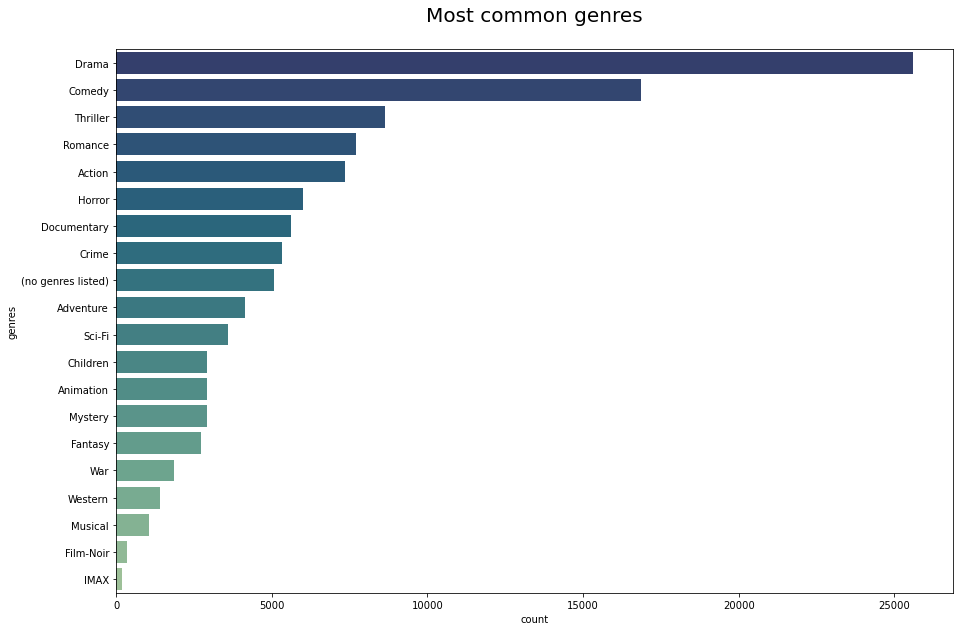

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(movies[['movieId', 'genres']],columns=['movieId', 'genres'])
# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))
# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='crest_r')
plt.show()

It seems people are into some... people like what they like ;)

Let's quickly take a look at `movies.csv`:

In [16]:
demo_frame(movies)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB
None


movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

It would be great to extract the year from the title... if only there was a pre-cleaned version to look at...

`scripts/data_cleaning.py` to the rescue! The function looks like this:

```python
def clean_movies():
    movies = pd.read_csv("data/movies.csv")

    movies["year"] = (
        movies.title.str.strip()
        .str[-6:]
        .str.extract(r"\(([0-9]{4})\)")
        .fillna(0)
        .astype(int)
    )

    normal_year_mean = movies[movies.year != 0].year.median()
    movies["year"].replace(0, normal_year_mean, inplace=True)

    movies["title"] = movies.title.str.strip().str.replace(
        r"\(([0-9]{4})\)", "", regex=True
    )
    movies["title"] = (
        movies["title"].str.strip().str.replace(r"(.*), The$", r"The \1", regex=True)
    )

    movies["title"] = movies["title"] + movies.year.apply(lambda y: f" ({int(y)})")

    movies["genres"] = movies.genres.str.replace(
        "(no genres listed)", "unknown", regex=False
    )

    movies.to_csv(
        "cleaned/movies.csv",
        index=False,
    )
```

In [17]:
# hah, there is!
movies= pd.read_csv('cleaned/movies.csv')

demo_frame(movies)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int64  
 1   title    62423 non-null  object 
 2   genres   62423 non-null  object 
 3   year     62423 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.9+ MB
None


movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres    year  
0  Adventure|Animation|Children|Comedy|Fantasy  1995.0  
1                   Adventure|Children|Fantasy  1995.0  
2                               Comedy|Romance  1995.0  
3                         Comedy|Drama|Romance  1995.0  
4                                       Comedy  1995.0

Excellent! Genres aren't too interesting, let's take a quick peak at movie releases per year and move on!

In [18]:
fig = px.histogram(movies, x='year', nbins=100, title='Movies released per year')
fig.show()

Not really any major insights here... The number of movies released per year is increasing over time - but that's relatively obvious. Later on, once we've brought in `train.csv` (which contains some timestamp info) we might be able to draw more insightful... insights.

Let's keep Exploring - `tags.csv` is next. We'll give it the same treatment we gave the plot keywords above:

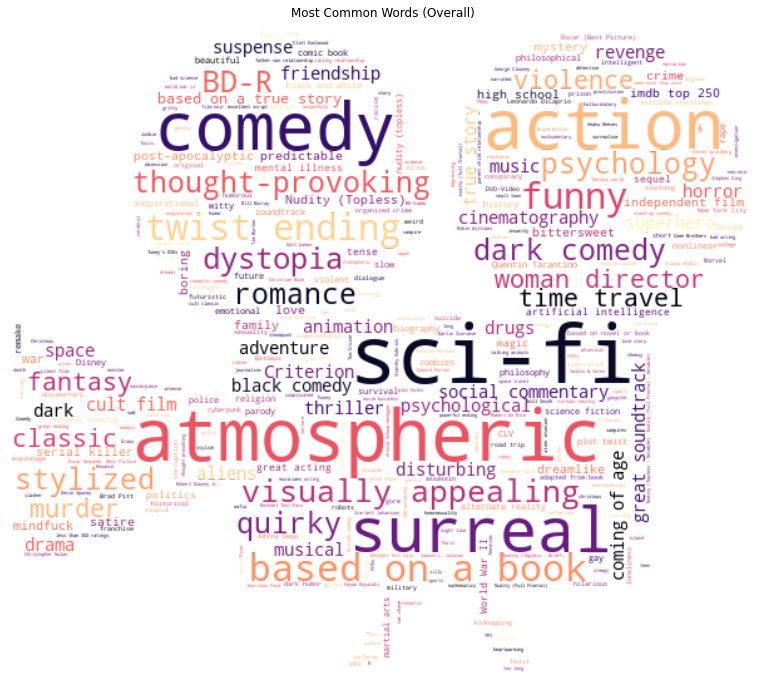

In [19]:
gen_wordcloud(pd.Series(Counter(tags.tag)), "Most Common Words (Overall)", savefig=False)

There are definitely some interesting tags here! We could potentially find similar users by how they tagged movies in some way! Let's carry on; The real meat of our data - the `train.csv` file!

In [20]:
demo_frame(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB
None


userId  movieId  rating   timestamp
0    5163    57669     4.0  1518349992
1  106343        5     4.5  1206238739
2  146790     5459     5.0  1076215539
3  106362    32296     2.0  1423042565
4    9041      366     3.0   833375837

Let's first how many movies each user has rated:

In [21]:
rating_count_by_user = train.groupby('userId').movieId.count().sort_values(ascending=False)
print(rating_count_by_user.iloc[:10])
print(rating_count_by_user.describe())

userId
72315     12952
80974      3680
137293     3588
33844      3208
20055      3050
109731     2671
49403      2670
92046      2579
110971     2288
30879      2284
Name: movieId, dtype: int64
count    162541.000000
mean         61.523173
std         107.410889
min           1.000000
25%          14.000000
50%          28.000000
75%          65.000000
max       12952.000000
Name: movieId, dtype: float64


Our top user has rated almost 13 thousand movies! The average number of ratings per user is 61, with the 25th percentile being 14 ratings. The median number of ratings is 28.

Considering ratings as features of users, to help recommend new content (Collaborative Filtering) definitely seems like a good idea as well.

We could use some statistical magic to reduce the total number of training samples. We do this by excluding movies that have fewer than 10 ratings, and users that have rated less than 10 movies.

In [22]:
rating_count_by_movie = train.groupby('movieId').userId.count().sort_values(ascending=False)
print(rating_count_by_movie.iloc[:10])
print(rating_count_by_movie.describe())

movieId
318     32831
356     32383
296     31697
593     29444
2571    29014
260     27560
480     25518
527     24004
110     23722
2959    23536
Name: userId, dtype: int64
count    48213.000000
mean       207.413727
std       1092.768777
min          1.000000
25%          1.000000
50%          4.000000
75%         26.000000
max      32831.000000
Name: userId, dtype: float64


In [23]:
from scipy.stats import zscore

active_users = rating_count_by_user[rating_count_by_user > 10]
zscores = np.abs(zscore(active_users))
active_uids = active_users[zscores < 3].index.values

active_movies = rating_count_by_movie[rating_count_by_movie > 10]
zscores = np.abs(zscore(active_movies))
active_mids = active_movies[zscores < 3].index.values

sample = train[train.userId.isin(active_uids) & train.movieId.isin(active_mids)]
demo_frame(sample)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5048118 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 192.6 MB
None


userId  movieId  rating   timestamp
0    5163    57669     4.0  1518349992
1  106343        5     4.5  1206238739
2  146790     5459     5.0  1076215539
4    9041      366     3.0   833375837
6   19630    62049     4.0  1246729817

There we have a sample! Let's see how we've influenced the sparsity:

In [24]:
def calc_sparsity(df):
    density = len(df) / (len(df.userId.unique()) * len(df.movieId.unique()))
    return 1 - density

print(f"Original Sparsity: {round(calc_sparsity(train) * 100.0, 2)} %")
print(f"Sampled Sparsity: {round(calc_sparsity(sample) * 100.0, 2)} %")

Original Sparsity: 99.87 %
Sampled Sparsity: 99.77 %


Not significantly changed - but now we have about half as much data to worry about! Let's go ahead and save this sample to a file:

In [25]:
sample.to_csv('cleaned/train_sample.csv')

In [26]:
print(train.rating.describe())
print(sample.rating.describe())

count    1.000004e+07
mean     3.533395e+00
std      1.061124e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64
count    5.048118e+06
mean     3.464265e+00
std      1.069986e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


The median rating given is 3.5, the mean is only slightly more at 3.53. Our sample also exhibits a very similar distribution.

Now about those *"more insightful insights"*, let's see if there is any relationship between the age of a movie and the rating given:

In [27]:
train['timestamp'] = pd.to_datetime(train["timestamp"], unit='s')
demo_frame(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   userId     int64         
 1   movieId    int64         
 2   rating     float64       
 3   timestamp  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 305.2 MB
None


userId  movieId  rating           timestamp
0    5163    57669     4.0 2018-02-11 11:53:12
1  106343        5     4.5 2008-03-23 02:18:59
2  146790     5459     5.0 2004-02-08 04:45:39
3  106362    32296     2.0 2015-02-04 09:36:05
4    9041      366     3.0 1996-05-29 13:17:17

In [28]:
combined = train.merge(movies[['movieId', 'year']], on='movieId', how='left')
combined['delay'] = train.timestamp.dt.year - combined.year

combined.head()

userId  movieId  rating           timestamp    year  delay
0    5163    57669     4.0 2018-02-11 11:53:12  2008.0   10.0
1  106343        5     4.5 2008-03-23 02:18:59  1995.0   13.0
2  146790     5459     5.0 2004-02-08 04:45:39  2002.0    2.0
3  106362    32296     2.0 2015-02-04 09:36:05  2005.0   10.0
4    9041      366     3.0 1996-05-29 13:17:17  1994.0    2.0

Now we can easily, per movie, see how it's ratings change over time (if at all)

In [29]:
subset = combined[(combined.year > 1950)]

In [30]:
by_delay = subset.groupby(['movieId', 'delay'], as_index=False).rating.agg(['mean', 'count'])
subset = by_delay[by_delay['count'] > 100].reset_index()
subset

movieId  delay      mean  count
0            1    1.0  4.131250   2560
1            1    2.0  3.849309   2389
2            1    3.0  3.929379    354
3            1    4.0  3.952236    984
4            1    5.0  4.152332   1372
...        ...    ...       ...    ...
22610   201773    0.0  3.730223    493
22611   202103    0.0  3.470588    119
22612   202429    0.0  3.878082    365
22613   202439    0.0  4.201571    191
22614   204698    0.0  4.000000    342

[22615 rows x 4 columns]

In [31]:
subset['rating_diff'] = subset.groupby('movieId')['mean'].diff(1).fillna(0)

In [32]:
fig = px.scatter(
    subset,
    x='delay',
    y='rating_diff',
    color='rating_diff',
    title='Change in rating over time'
)
fig.update_layout(showlegend=False)
fig.show()

`delay` represents how many years after a movie was released the rating was given.

What this colorful mess above is saying is: Movie ratings don't seem to change very much over time.



## Users and movies

Here we are going to explore the user database and perform user behaviour analysis.

First we will check the number users.

In [33]:
uniq_users = train["userId"].nunique()
uniq_movies = train["movieId"].nunique()
total_users = len(train["userId"])
total_movies = len(train["movieId"])

print(
    "The total number of unique users is {}, \n"
    "which makes up {:.2%} of the total user entries/reviews \n"
    "The total number of unique movies is {},\n"
    "which makes up {:.2%} of the total movie entries/reviewss".format(
        uniq_users,
        uniq_users/total_users,
        uniq_movies,
        uniq_movies/total_movies,
    )
)

The total number of unique users is 162541, 
which makes up 1.63% of the total user entries/reviews 
The total number of unique movies is 48213,
which makes up 0.48% of the total movie entries/reviewss


This shows that there is a very low percentage of unique users and movies that were reviewed. The ratios, unique users:total users entries and unique movies:total movies entries are important as they help in strengthening the reliability of of the data. For example, 1000 reviews is more reliable data about Movie A than 100 reviews.


Now, we will check how users have been finding these movies. We will do this by looking at the ratings the users have given to each movie.


Ratings are used as feedback from users to determine what users think about a movie, if whether a user, or a group of users, liked the movie they watched. Here we will explore and mine some insights in terms of what most popular scores are being rated by users.

Below we created a table that show the frequency of a set of scores.

In [34]:
# Determining number of rows for each rating value
rating_count = train["rating"].value_counts()
df_rating_count = pd.DataFrame(
    {"rating": rating_count.index, 
     "Frequency": (train["rating"].value_counts()).values,
    })
df_rating_count

rating  Frequency
0     4.0    2652977
1     3.0    1959759
2     5.0    1445230
3     3.5    1270642
4     4.5     880516
5     2.0     656821
6     2.5     505578
7     1.0     311213
8     1.5     159731
9     0.5     157571

As you can see above, the most common score is 4.0, followed by 3.0, and tailing with 1.5 and 0.5 ratings. To better visualize this, we have created a bar graph and a pie chart as shown below.

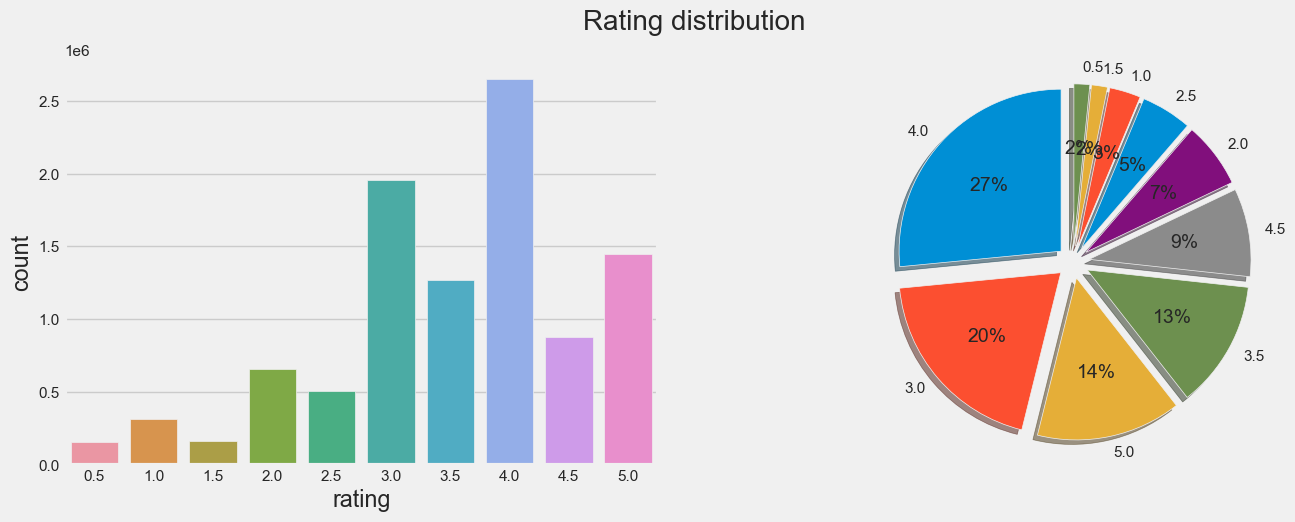

In [35]:
# Import matplotlib style for visuals
import matplotlib.style as style
sns.set(font_scale=1.0)
style.use('fivethirtyeight')  # visual style picked

fig, axes = plt.subplots(ncols=2,
                         nrows=1,
                         figsize=(15, 5),
                         dpi=100)

sns.countplot(x=train['rating'], ax=axes[0])

labels = df_rating_count.rating

axes[1].pie(train['rating'].value_counts(),
            labels=labels,
            autopct='%1.0f%%',
            shadow=True,
            startangle=90,
            explode=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1))

fig.suptitle('Rating distribution', fontsize=20)
plt.show()

According to the figures above, we can see that every once in four times a movie was rated a score of 4.0, which is the most common score. This would be a result of the fact that mostly people chose to watch movies they rather enjoy than not, and therefore they are most likely to give it a better. This explains the very low rating count on the lower ratings; users are most likely not going to watch what they are most likely not going to enjoy.

# Step 3: Preprocessing

As mentioned above, we've done most of our preprocessing in our `data_cleaning.py` script. 

# Step 4: Bring in the models!

Finally! Am I right? First we need to talk about the types of models for recommendations:

There are in essence 3:
- Content-based filtering
- Collaborative filtering
- Hybrid (combine the 2 above + some other stuff)

Scary-sounding stuff right? Basically; All recommendation is about showing a user things they'll like. How do we know what they'll like?
- based on what else they've liked, ie. we find *content* that is similar to what they've already liked
- based on what similar people have liked, ie. our users *collaborate* (work together) to suggest things to each other (indirectly)

How we determine similarity is largely an embedding problem with some math sprinkled in - we don't need to get into too much details. In essence we try to represent each *thing* as a vector (think like a 2d (x, y) point in space, but with more dimentions), and then through the magic of math & information theory things that are similar *should* be close together (either measure by distance between them or angle between them).

## There is one more distinction we should make:
- For the Kaggle competition, which is the primary goal of this Notebook, we are given a user's rating history, we are then asked to predict what a specific user would rate new (unseen) movies.

- We are also working on a StreamLit app, where we are given only 3 of a user's favourite movies - we must then recommend n (usually 10) new (unseen) movies.

The problems are similar but require slightly different approaches to be optimal.

1. For the Kaggle competition (i.e. predicting ratings), we'll use a custom version of Surprise (found here: https://github.com/ProfHercules/Surprise) - the primary difference is that it is faster to train.

2. For the StreamLit app we'll be using a library called `implicit`, found here: https://github.com/benfred/implicit

We'll start off by looking at **collaborative models**
## Collaborative Filtering


In [36]:
# basic models
from surprise import NormalPredictor, BaselineOnly
# knn based models
from surprise import KNNBasic, KNNWithMeans, KNNBaseline
# matrix factorization models
from surprise import SVD, SVDpp, NMF
# other clustering models
from surprise import SlopeOne, CoClustering

# some tools to bring in our data
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate, GridSearchCV

### The plan is as follows:
We'll start with only default hyperparameters

1. We'll compare all of the models on a sample of the `sample` we generated earlier.
2. Then we'll move up to a bigger sample giving the models about 5x as much data, to see how the runtime changes
3. Finally we'll pick a final model and use `comet_ml` to Optimize it using an improved Grid Search.

In [37]:
models = (
    NormalPredictor, BaselineOnly,  # boring models
    KNNBasic, KNNWithMeans, KNNBaseline, # kmeans models
    SVD, SVDpp, NMF, # matrix factorization models
    SlopeOne, CoClustering # clustering models
)

In [38]:
sample_x = sample.sample(n=5_000, random_state=42)
sample_x = Dataset.load_from_df(sample_x[['userId', 'movieId', 'rating']], reader=Reader(rating_scale=(0.5, 5)))

sample_5x = sample.sample(n=25_000, random_state=42)
sample_5x = Dataset.load_from_df(sample_5x[['userId', 'movieId', 'rating']], reader=Reader(rating_scale=(0.5, 5)))

In [39]:
results = {
    "model": [],
    "train_rmse_mean": [],
    "train_rmse_std": [],
    "test_rmse_mean": [],
    "test_rmse_std": [],
    "fit_time_mean": [],
    "fit_time_std": [],
    "test_time_mean": [],
    "test_time_std": [],
}
for idx, model in enumerate(models):
    print(idx, model.__name__)
    result = cross_validate(
        algo=model(), 
        data=sample_x, 
        cv=3,
        measures=['rmse'], 
        n_jobs=-1, 
        return_train_measures=True
    )
    results['model'].append(model.__name__)
    results['train_rmse_mean'].append(result['train_rmse'].mean())
    results['train_rmse_std'].append(result['train_rmse'].std())

    results['test_rmse_mean'].append(result['test_rmse'].mean())
    results['test_rmse_std'].append(result['test_rmse'].std())

    results['fit_time_mean'].append(np.array(result['fit_time']).mean())
    results['fit_time_std'].append(np.array(result['fit_time']).std())

    results['test_time_mean'].append(np.array(result['test_time']).mean())
    results['test_time_std'].append(np.array(result['test_time']).std())

0 NormalPredictor
1 BaselineOnly
2 KNNBasic
3 KNNWithMeans
4 KNNBaseline
5 SVD
6 SVDpp
7 NMF
8 SlopeOne
9 CoClustering


In [40]:
result_df = pd.DataFrame(results).set_index('model', drop=True)
result_df.sort_values("test_rmse_mean")

train_rmse_mean  train_rmse_std  test_rmse_mean  \
model                                                              
SVDpp                   0.730257        0.002379        1.064979   
KNNBaseline             0.248886        0.002931        1.065912   
SVD                     0.719256        0.001954        1.065916   
BaselineOnly            0.922409        0.011640        1.066687   
KNNBasic                0.265443        0.002861        1.077829   
SlopeOne                0.036507        0.003416        1.088100   
KNNWithMeans            0.075932        0.005944        1.090452   
NMF                     0.183244        0.004347        1.091904   
CoClustering            0.813989        0.084042        1.099974   
NormalPredictor         1.476792        0.021352        1.461355   

                 test_rmse_std  fit_time_mean  fit_time_std  test_time_mean  \
model                                                                         
SVDpp                 0.009424       0.015190      0.000608        0.004621   
KNNBaseline           0.009921       0.149690      0.005450        0.004929   
SVD                   0.005204       0.022378      0.000012        0.004418   
BaselineOnly          0.024967       0.006484      0.000038        0.004079   
KNNBasic              0.013081       0.120581      0.008948        0.005243   
SlopeOne              0.023293       0.052770      0.002002        0.004802   
KNNWithMeans          0.009557       0.133371      0.014880        0.006833   
NMF                   0.016367       0.191317      0.001337        0.004441   
CoClustering          0.013660       0.221531      0.003147        0.003555   
NormalPredictor       0.009658       0.001921      0.000053        0.005910   

                 test_time_std  
model                           
SVDpp                 0.000178  
KNNBaseline           0.000217  
SVD                   0.000180  
BaselineOnly          0.000111  
KNNBasic              0.000346  
SlopeOne              0.000138  
KNNWithMeans          0.002146  
NMF                   0.000088  
CoClustering          0.000027  
NormalPredictor       0.000165

Most of the models perfrom similarly, clearly we don't need to consider the `NormalPredictor` (which is essentially just random guessing) any further. 

We might also exclude all models that performed worse than `BaselineOnly`, since it's just guessing means - doing worse than this isn't really valuable.

We should also consider overfitting - let's look at the difference between train and test RMSE across all models:

In [41]:
(result_df.train_rmse_mean - result_df.test_rmse_mean).abs().sort_values()

model
NormalPredictor    0.015437
BaselineOnly       0.144279
CoClustering       0.285984
SVDpp              0.334722
SVD                0.346661
KNNBasic           0.812387
KNNBaseline        0.817026
NMF                0.908660
KNNWithMeans       1.014520
SlopeOne           1.051593
dtype: float64

Clearly All our complex - i.e. matrix factorization - models are overfitting quite a bit! 

Thankfully this can be alleviated by increasing the regularisation hyperparamter; something we'll get to later.

Let's run the same test on the MovieLens 1M dataset - that should prove insightful too!
(We'll switch the cross-validation to 2 fold in the interest of saving time.)

In [42]:
results_5x = {
    "model": [],
    "train_rmse_mean": [],
    "train_rmse_std": [],
    "test_rmse_mean": [],
    "test_rmse_std": [],
    "fit_time_mean": [],
    "fit_time_std": [],
    "test_time_mean": [],
    "test_time_std": [],
}
for idx, model in enumerate(models):
    print(idx, model.__name__)
    result = cross_validate(
        algo=model(), 
        data=sample_5x, 
        cv=3,
        measures=['rmse'], 
        n_jobs=-1, 
        return_train_measures=True
    )
    results_5x['model'].append(model.__name__)
    results_5x['train_rmse_mean'].append(result['train_rmse'].mean())
    results_5x['train_rmse_std'].append(result['train_rmse'].std())

    results_5x['test_rmse_mean'].append(result['test_rmse'].mean())
    results_5x['test_rmse_std'].append(result['test_rmse'].std())

    results_5x['fit_time_mean'].append(np.array(result['fit_time']).mean())
    results_5x['fit_time_std'].append(np.array(result['fit_time']).std())

    results_5x['test_time_mean'].append(np.array(result['test_time']).mean())
    results_5x['test_time_std'].append(np.array(result['test_time']).std())

0 NormalPredictor
1 BaselineOnly
2 KNNBasic
3 KNNWithMeans
4 KNNBaseline
5 SVD
6 SVDpp
7 NMF
8 SlopeOne
9 CoClustering


In [43]:
result_df_5x = pd.DataFrame(results_5x).set_index('model', drop=True)
result_df_5x.sort_values("test_rmse_mean")

train_rmse_mean  train_rmse_std  test_rmse_mean  \
model                                                              
SVDpp                   0.740738        0.001031        1.032146   
SVD                     0.707025        0.001343        1.035876   
BaselineOnly            0.913774        0.002301        1.035915   
KNNBaseline             0.397081        0.001331        1.036851   
KNNBasic                0.424267        0.000297        1.073689   
SlopeOne                0.076150        0.000533        1.131374   
NMF                     0.106913        0.000926        1.132692   
KNNWithMeans            0.238096        0.003488        1.132763   
CoClustering            0.794608        0.117271        1.140807   
NormalPredictor         1.469751        0.004514        1.464672   

                 test_rmse_std  fit_time_mean  fit_time_std  test_time_mean  \
model                                                                         
SVDpp                 0.000659       0.081053      0.000317        0.032037   
SVD                   0.003755       0.150409      0.030268        0.051369   
BaselineOnly          0.004546       0.026169      0.000603        0.020152   
KNNBaseline           0.000437       4.178491      0.028599        0.052912   
KNNBasic              0.011516       4.449879      0.020461        0.051156   
SlopeOne              0.002110       0.336666      0.013872        0.034780   
NMF                   0.006834       0.747786      0.003317        0.023109   
KNNWithMeans          0.008423       4.241291      0.014878        0.046777   
CoClustering          0.009112       0.809305      0.003056        0.022666   
NormalPredictor       0.007591       0.009645      0.000238        0.030155   

                 test_time_std  
model                           
SVDpp                 0.000216  
SVD                   0.026184  
BaselineOnly          0.000393  
KNNBaseline           0.007229  
KNNBasic              0.005651  
SlopeOne              0.004945  
NMF                   0.000237  
KNNWithMeans          0.007401  
CoClustering          0.003711  
NormalPredictor       0.004216

Let's verify the degree of overfitting again:

In [44]:
(result_df_5x.train_rmse_mean - result_df_5x.test_rmse_mean).abs().sort_values()

model
NormalPredictor    0.005079
BaselineOnly       0.122141
SVDpp              0.291408
SVD                0.328851
CoClustering       0.346199
KNNBaseline        0.639770
KNNBasic           0.649423
KNNWithMeans       0.894666
NMF                1.025779
SlopeOne           1.055224
dtype: float64

We see roughly the same degree of overfitting, with drastically better accuracy scores. 

Let's see how much longer the models took to train:

In [45]:
(result_df_5x / result_df).sort_values('fit_time_mean', ascending=False)

train_rmse_mean  train_rmse_std  test_rmse_mean  \
model                                                              
KNNBasic                1.598335        0.103904        0.996159   
KNNWithMeans            3.135674        0.586899        1.038801   
KNNBaseline             1.595431        0.454049        0.972736   
SVD                     0.982996        0.687522        0.971818   
SlopeOne                2.085908        0.155904        1.039770   
SVDpp                   1.014353        0.433523        0.969171   
NormalPredictor         0.995232        0.211408        1.002270   
BaselineOnly            0.990639        0.197641        0.971152   
NMF                     0.583447        0.213093        1.037355   
CoClustering            0.976190        1.395383        1.037122   

                 test_rmse_std  fit_time_mean  fit_time_std  test_time_mean  \
model                                                                         
KNNBasic              0.880411      36.903774      2.286540        9.757849   
KNNWithMeans          0.881324      31.800612      0.999905        6.845800   
KNNBaseline           0.044038      27.914285      5.247395       10.735448   
SVD                   0.721602       6.721267   2505.106133       11.628234   
SlopeOne              0.090590       6.379865      6.929345        7.242288   
SVDpp                 0.069909       5.335946      0.520358        6.932587   
NormalPredictor       0.785923       5.019730      4.490298        5.102633   
BaselineOnly          0.182072       4.036024     15.728629        4.939918   
NMF                   0.417567       3.908619      2.480611        5.203858   
CoClustering          0.667058       3.653243      0.970925        6.376618   

                 test_time_std  
model                           
KNNBasic             16.308211  
KNNWithMeans          3.448231  
KNNBaseline          33.332939  
SVD                 145.451570  
SlopeOne             35.940091  
SVDpp                 1.217483  
NormalPredictor      25.549288  
BaselineOnly          3.537385  
NMF                   2.690339  
CoClustering        139.985694

Holy bananas batman! Looking at `fit_time_mean` some of the models' training time changed much more drastically given 5x as much data.

The `KNNWithMeans`, `KNNBaseline`, and `KNNBasic` all had their training times increase a lot more than 5x. 

We cannot consider them further, given that real-world data may scale into the hundreds of millions or even billions! We don't have until the heat death of the universe to train a model.

A quick look at the code of some of the models reveals some are implemented in pure python - so there is much room for improvement.

Still though, our only reasonable option seems to be `SVD`. `SVDpp` trains **much** more slowly than `SVD`, even if it is slightly better.

Before we get to optimizing our Collaborative model, let's check out...

## Content-based Filtering

We'll first combine all of the data we have on any movie into a single massive dataset using the following script:

```python
def build_full_combine():
    train = pd.read_csv("data/train.csv")
    movies = pd.read_csv("cleaned/movies.csv")
    imdb_data = pd.read_csv("cleaned/imdb_data.csv")
    genome_tag_vec = pd.read_csv("cleaned/genome_tag_vec.csv")

    full_combine = (
        movies.merge(imdb_data, on="movieId", how="left")
        .merge(genome_tag_vec, on="movieId", how="left")
        .set_index("movieId", drop=True)
    )

    normal_year_mean = full_combine[full_combine.year != 0].year.mean()
    full_combine["year"].replace(0, normal_year_mean, inplace=True)

    # movies.year.fillna(int(movies.year.median()), inplace=True)
    # movies.genres.fillna("<unknown>", inplace=True)
    full_combine.title = full_combine.title.str.strip().str.replace(
        r"(.*), The$", r"The \1", regex=True
    )
    full_combine.title_cast.fillna(" ", inplace=True)
    full_combine.director.fillna(" ", inplace=True)
    full_combine.runtime.fillna(int(full_combine.runtime.median()), inplace=True)
    full_combine.budget.fillna(int(full_combine.budget.median()), inplace=True)
    full_combine.plot_keywords.fillna(" ", inplace=True)

    full_combine["cast_size"] = full_combine.title_cast.str.split("|").apply(len)
    full_combine["genre_count"] = full_combine.genres.str.split("|").apply(len)

    movie_groups = train.set_index("movieId", drop=True).groupby("movieId")
    full_combine["rating_mean"] = movie_groups.rating.mean()
    full_combine["rating_std"] = movie_groups.rating.std().fillna(0)

    q3 = movie_groups.rating.quantile(0.75)
    q1 = movie_groups.rating.quantile(0.25)

    full_combine["rating_iqr"] = q3 - q1
    full_combine["rating_count"] = movie_groups.apply(len)

    full_combine.fillna(0, inplace=True)

    full_combine["movieId"] = full_combine.index.values
    full_combine.reset_index(inplace=True, drop=True)
    full_combine.to_csv(
        "cleaned/full_combine.csv",
        index=False,
    )
```

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

from sklearn.metrics.pairwise import cosine_similarity

from scipy import sparse

import nltk
from nltk.corpus import stopwords

stopwords = stopwords.words('english')

In [47]:
full_combine = pd.read_csv('cleaned/full_combine.csv')

This humongus dataframe allows us to easily build some feature vectors; first we'll build one for genres:

In [48]:
features = []

In [49]:
genre_vectrz = CountVectorizer(token_pattern=r"[A-z\-]+", min_df=2)
genre_vec = genre_vectrz.fit_transform(full_combine.genres)
print("Genre Tokens:", len(genre_vectrz.get_feature_names()))
features.extend(genre_vectrz.get_feature_names())

Genre Tokens: 20


We'll repeat this process for cast, director, and plot keywords, and we'll even sprinkle in some of those genome tags.

In [50]:
cast_vectrz = CountVectorizer(token_pattern=r"[^\|]+", min_df=20)
cast_vec = cast_vectrz.fit_transform(full_combine.title_cast)
print("Cast Tokens:", len(cast_vectrz.get_feature_names()))
features.extend(cast_vectrz.get_feature_names())

Cast Tokens: 818


In [51]:
director_vectrz = CountVectorizer(token_pattern=r".+", min_df=10, stop_words=['see full summary'])
director_vec = director_vectrz.fit_transform(full_combine.director)
print("Director Tokens:", len(director_vectrz.get_feature_names()))
features.extend(director_vectrz.get_feature_names())

Director Tokens: 31


In [52]:
plot_vectrz = CountVectorizer(token_pattern=r"[^\|]+", min_df=10, stop_words=stopwords)
plot_vec = plot_vectrz.fit_transform(full_combine.plot_keywords)
print("Plot KW Tokens:", len(plot_vectrz.get_feature_names()))
features.extend(plot_vectrz.get_feature_names())

Plot KW Tokens: 1002


In [53]:
genome_features = [col for col in genome_tag_vec.columns if col != 'movieId']
features.extend(genome_features)
sparse_genome = sparse.csr_matrix(full_combine[genome_features])

Now we can easily combined all of these different sparse matrices to produce on final one:

In [54]:
extra_features = ["year", "runtime", "budget", "rating_mean", "rating_std", "rating_iqr", "rating_count"]
features.extend(extra_features)

extra_features = full_combine[extra_features]

scaler = MinMaxScaler()
transformed = scaler.fit_transform(extra_features)
std_extra_sparse = sparse.csr_matrix(transformed)

tfidf_vecs = sparse.hstack([
    # title_vec,
    genre_vec,
    cast_vec,
    director_vec,
    plot_vec,
]).tocsr()

vecs = sparse.hstack([tfidf_vecs, sparse_genome, std_extra_sparse])
norm = Normalizer(copy=True)
norm_vecs = norm.transform(vecs)
norm_vecs.shape

(62423, 3006)

We use the `Normalizer` since the cosine similarity between any 2 (l2 normalized) vectors is the same as their dot-product. Thus we can now easily get a list of the top n similar movies to a specified movie:

In [55]:
from collections import OrderedDict

def top_n_similar_to(movieId: int, n=10) -> OrderedDict:
    results = dict()
    movie_idx = movies[movies['movieId'] == movieId].index[0]
    similarities = norm_vecs.dot(norm_vecs.getrow(movie_idx).transpose()).toarray().flatten()
    top_n = similarities.argsort(axis=0)[-n-1:-1][::-1]

    for similar_idx in top_n:
        title = full_combine.iloc[similar_idx].title
        sim = round(similarities[similar_idx] * 100.0, 0)
        results[title] = (sim, similar_idx)
        
    return OrderedDict(sorted(results.items(), key=lambda kv: kv[1], reverse=True))

def batch_similar_to(movies: [int], n=10):
    results = dict()
    for mid in movies:
        res = top_n_similar_to(mid, n=n)
        for movie, (sim, idx) in res.items():
            if (movie in results) and (results[movie][0] < sim):
                results[movie] = (sim, idx)
            else:
                results[movie] = (sim, idx)

    return OrderedDict(sorted(results.items(), key=lambda kv: kv[1], reverse=True)[:n])

And a quick demo:

In [56]:
avengers = 89745
avengers2 = 122892
amazing_spiderman = 95510
fault_in_stars = 111921

import pprint 
pp = pprint.PrettyPrinter(indent=4)

pp.pprint(top_n_similar_to(avengers))
print()
pp.pprint(batch_similar_to([amazing_spiderman, fault_in_stars]))

OrderedDict([   ('Iron Man (2008)', (90.0, 12324)),
                ('Captain America: The Winter Soldier (2014)', (88.0, 21348)),
                ('Iron Man 2 (2010)', (88.0, 14628)),
                ('Ant-Man (2015)', (87.0, 25061)),
                ('Avengers: Age of Ultron (2015)', (87.0, 25058)),
                ('Doctor Strange (2016)', (86.0, 25072)),
                ('Iron Man 3 (2013)', (86.0, 19678)),
                ('Thor (2011)', (86.0, 16312)),
                ('Guardians of the Galaxy (2014)', (85.0, 21936)),
                ('Spider-Man (2002)', (85.0, 5241))])

OrderedDict([   ('The Amazing Spider-Man 2 (2014)', (90.0, 21454)),
                ('Superman Returns (2006)', (88.0, 10890)),
                ('Justice League (2017)', (87.0, 25060)),
                ('Avengers: Age of Ultron (2015)', (86.0, 25058)),
                ('The Wolverine (2013)', (86.0, 20018)),
                ('Spider-Man (2002)', (86.0, 5241)),
                ('Me Before You (2016)', (85.0, 3715

Amazing! Well... semi-amazing. It works! We'll keep working to improve the collaborative models since they are in need of the most optimization. Content-based works, but it's not as magical.

## Comet Optimizer

`comet_ml` has a nice built in class called an `Optimizer` which implements bayesian optimization as an alternative approach to a raw grid search.

Within `scripts/optimize.py` you'll find the following code:

```python
import sys

import comet_ml
import numpy as np
from comet_ml import Optimizer
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate

import pandas as pd

comet_ml.init(
    api_key="A33C91N4gmBuLOlY0TK57mmI0",
    project_name="movie-lens-unsup",
    workspace="profhercules",
)
print("Loading data...")
df = pd.read_csv("../cleaned/train_sample.csv").sample(n=250_000, random_state=42)
data = Dataset.load_from_df(
    df[["userId", "movieId", "rating"]], Reader(rating_scale=(0.5, 5))
)
del df

opt = Optimizer(
    sys.argv[1],
    trials=1,
    verbose=0,
    experiment_class="OfflineExperiment",
    offline_directory="./experiments_sampled",
    log_code=False,
    log_git_patch=False,
)


def fit(
    n_factors: int,
    n_epochs: int,
    init_mean: float,
    init_std_dev: float,
    lr_all: float,
    reg_all: float,
):
    algo = SVD(
        n_factors=n_factors,
        n_epochs=n_epochs,
        init_mean=init_mean,
        init_std_dev=init_std_dev,
        lr_all=lr_all,
        reg_all=reg_all,
        random_state=42,
        verbose=False,
    )

    results = cross_validate(
        algo=algo,
        data=data,
        measures=["rmse"],
        return_train_measures=True,
        cv=5,
        n_jobs=1,
        verbose=False,
    )

    return (
        results["test_rmse"].mean(),
        results["train_rmse"].mean(),
        np.array(results["fit_time"]).mean(),
        np.array(results["test_time"]).mean(),
    )


# Finally, get experiments, and train your models:
for experiment in opt.get_experiments():
    # get parameters:
    (test_rmse, train_rmse, fit_time, test_time) = fit(
        n_factors=experiment.get_parameter("n_factors"),
        n_epochs=experiment.get_parameter("n_epochs"),
        init_mean=experiment.get_parameter("init_mean"),
        init_std_dev=experiment.get_parameter("init_std_dev"),
        lr_all=experiment.get_parameter("lr_all"),
        reg_all=experiment.get_parameter("reg_all"),
    )

    experiment.log_metric("test_rmse", test_rmse)
    experiment.log_metric("train_rmse", train_rmse)
    experiment.log_metric("fit_time", fit_time)
    experiment.log_metric("test_time", test_time)
    experiment.add_tags(["SVD", "ML-full-sampled", "CV-5"])
    experiment.end()

```


The results of these experiments are uploaded to Comet after-the-fact. Our comet project is public and can be viewed here: https://www.comet.ml/profhercules/movie-lens-unsup

Feel free to play around with the filters as you wish.


## We'll now explore our final batch of models
specifically the `AlternatingLeastSquares` model from `implicit`.

ALS uses a similar approach to SVD++ in that it notices the fact *that* a user rated a movie, not only what the rating is. This is called an *implicit* interaction. ALS is 'embarrassingly parallel' as the author puts it and it trains incredibly fast. Usages is similar to Surprise but a bit more involved.

We include below the `train_colbases.py` script from our StreamLit app; please check out that app for a full demo of ALS in action - it is incredibly fast!

```python
import pandas as pd
from implicit.als import AlternatingLeastSquares

# some fancy helpers
from helpers import save_it, sparse_pivot

# load in training data
train = pd.read_csv("./resources/data/train.csv")

# standardize ratings since `implicit` uses negative values to indicate dislike
r_mean = train.rating.mean()
r_std = train.rating.std()
train["rating"] = (train.rating - train.rating.mean()) / train.rating.std()

# use sparse pivot helper function to generate a low-memory usage sparse matrix
item_user_train = sparse_pivot(
    df=train,
    index="movieId",  # rows are movieIds
    columns="userId",  # cols are userIds
    values="rating",  # values are ratings
)

# setup the ALS model with basically default parameters
model = AlternatingLeastSquares(factors=100, random_state=42)

# train the model on our sparse matrix
model.fit(item_user_train)

# save the model
save_it(model, filename="resources/models/als_implicit.pkl")

# load in movie data for help generating some maps
movies = pd.read_csv("./resources/cleaned/movies.csv")

# get sorted list of movie ids
movieIds = sorted(train.movieId.unique())
# generate a map to turn a movieId into an index inside the sparse matrix
mid_idx_map = {mid: i for i, mid in enumerate(movieIds)}
# generate a map to turn an index inside the sparse matrix into a movieId
idx_mid_map = {i: mid for i, mid in enumerate(movieIds)}
# generate a map between movieId and titles
mid_title_map = dict(movies[["movieId", "title"]].to_records(index=False))

# save our mappings
maps = (movieIds, mid_idx_map, idx_mid_map, mid_title_map)
save_it(maps, filename="resources/models/movie_maps.pkl")
```


# Step 5: Who's a good model?

As mentioned at the end of the Collaborative section we'll be sticking to the `SVD` model.

The following code is copied verbatim from the `scripts/train_model.py` file and is partially the result of the above comet Optimizer:

```python
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split

from surprise.dump import dump


random_state = 42

reader = Reader(
    name=None,
    line_format="user item rating",
    sep=",",
    rating_scale=(0.5, 5),
    skip_lines=1,
)

print("Loading data...")
data = Dataset.load_from_file("data/train.csv", reader)

print("Building training file")
train_set = data.build_full_trainset()

del data
del reader

algo = SVD(
    n_factors=200,
    n_epochs=30,
    lr_all=0.005,
    reg_all=0.02,
    init_std_dev=0.02,
    random_state=42,
    verbose=True,
)

print("Fitting...")
algo.fit(train_set)

print("Dumping...")
dump("model.pkl", algo=algo, verbose=1)

```

# Step 6: The Proof is in the Pudding

Having found the best possible model (within reason), we now have to make a `submission.csv` file to upload to Kaggle for scoring.

Once again, the code comes from `scripts/make_submission.py`

```python
from surprise.dump import load
import pandas as pd

print("Loading model...")
_, algo = load("model.pkl")

print("Loading prediction data...")
test = pd.read_csv("data/test.csv")

preds = dict()

print("Predicting...")
total = len(test)

for idx, (uid, mid) in enumerate(test.to_records(index=False)):
    _, _, _, est, details = algo.predict(str(uid), str(mid))

    if details["was_impossible"]:
        print(idx, "Impossible")

    pred_id = f"{uid}_{mid}"
    preds[pred_id] = est

    if ((idx + 1) % 343_000) == 0:
        print("[progress]", round(idx / total * 100.0, 1), "%")

print("Producing output csv...")
pd.Series(preds, name="rating", index=preds.keys()).to_csv(
    "submission.csv", index_label="Id"
)

```

# Step 7: Goodbye.

In this Notebook we quickly explored the Movie Lens dataset & built some models to exploit it. We learned about collaborative- & content-based filtering methods for recommender algorithms & gained an understanding of how to use Surprise. 

We also (very) briefly touched on `Implicit` which is another library used for recommendation engines.

We also discovered that people on the internet are not ashamed to like what they like ;)

# In summary:
- Collaborative models use various methods to perform dimensionality reduction on a user-item matrix in order to discover some latent features.
- Content based models attempt to define how similar two items are, and then attempts to use this similarity metric to recommend items.
- Hybrid approaches that combine these methods do exist, however we have not explored them (yet).
- The cold start problem is not as big a problem as it sounds;
    - If a user seems anonymous we just recommend popular items
    - Through these recommendations we quickly discover what they do and do not like.
